In [120]:
from libs.seq2seq_model import RNNModel, TCNModel, S4DModel
import matplotlib.pyplot as plt
import numpy as np
import glob
import torch
import os
from libs.train_cfd import get_slices
def get_rho_lstsq(x,y, end_point=False, ydim=0):
    path_length = x.shape[1]
    data_num = x.shape[0]
    dim=x.shape[2]
    rho = []

    
    if not end_point:
        X = []
        Y = []
        for i in range(path_length):
            Y.append(y[:,i,ydim][:,None])
        Y = np.vstack(Y)

        for i in range(1, path_length+1):
            X.append(np.hstack([np.zeros((data_num,path_length*dim-i*dim)), x[:,:i,:].reshape(data_num,i*dim)]))
        X = np.vstack(X)
    else:
        X=x.reshape(data_num,path_length*dim)
        Y=y[:,:,0]

    # r = np.linalg.lstsq(X, Y)[0]
    from sklearn.linear_model import LinearRegression
    reg = LinearRegression(n_jobs=6).fit(X, Y)
    rho = reg.coef_

    rho = rho.reshape(path_length, dim)
    return np.flip(rho)
def plot_result(re, index1, index2, model):
    latest_file = max(glob.glob(f'runs/cfd_Re{re}_{index1}_{index2}_{model}/version_0/checkpoints/*'), key=os.path.getctime)
    if model == 'RNN':
        model = RNNModel.load_from_checkpoint(latest_file)
    elif model == 'TCN':
        model = TCNModel.load_from_checkpoint(latest_file)
    elif model == 'S4D':
        model = S4DModel.load_from_checkpoint(latest_file)
    data = []
    for i in range(6):
        data.append(np.load(f"cyl_cfd/Re{re}/p{i+1}.npy"))

    
    # x = np.array(np.array_split(data[index1], 400)[1:])
    # y = np.array(np.array_split(data[index2], 400)[1:])
    x = get_slices(data[index1], 64, 0)[...,[1,2]]
    y = get_slices(data[index2], 64, 0)[...,[1,2]]

    model.eval()
    y_hat = model(torch.tensor(x, dtype=torch.float32)).detach().numpy()
    
    fig, ax = plt.subplots(2,2,figsize=(25,10))
    ax = ax.flatten()

    ax[0].plot( np.concatenate(x[:,:,0]))
    ax[0].set_title(f'u at Point {index1}')

    ax[1].plot( np.concatenate(x[:,:,1]))
    ax[1].set_title(f'v at Point {index1}')

    ax[0].set_xlim(500, 2500)
    ax[1].set_xlim(500, 2500)


    ax[2].plot( np.concatenate(y[:,:,0]))
    ax[2].plot( np.concatenate(y_hat[:,:,0]))
    ax[2].set_title(f'u at Point {index2}')

    ax[3].plot( np.concatenate(y[:,:,1]))
    ax[3].plot( np.concatenate(y_hat[:,:,1]))
    ax[3].set_title(f'v at Point {index2}')

    ax[2].set_xlim(500, 2500)
    ax[3].set_xlim(500, 2500)

    # ax[2].plot(get_rho_lstsq(x[...,1:], y))
    
    # print(x.shape, y.shape)

    fig.suptitle(f'Re: {re}, Input: Point {index1}, Output: Point {index2}', fontsize=16)
    # plt.savefig('1.png', dpi=600)
    # x = (x-x.min(axis=0))/(x.max(axis=0)-x.min(axis=0))
    # y = (y-y.min(axis=0))/(y.max(axis=0)-y.min(axis=0))

    r = [get_rho_lstsq(x,y,ydim=i) for i in range(2)]
    fig, ax = plt.subplots(1, 4, figsize=(15, 4))
    ax = ax.flatten()
    index = ['u', 'v']
    for i in range(2):
        for j in range(2):
            ax[i+2*j].plot(r[i][:,j])
            ax[i+2*j].title.set_text(f'{index[i]} -- {index[j]}')
            # ax[i,j].xlim([0,1])
            # ax[i+2*j].set_ylim([-1,1])

    # y_hat = (y_hat-y_hat.min(axis=0))/(y_hat.max(axis=0)-y_hat.min(axis=0))

    r = [get_rho_lstsq(x,y_hat,ydim=i) for i in range(2)]
    fig, ax = plt.subplots(1, 4, figsize=(15, 4))
    ax = ax.flatten()
    index = ['u', 'v']
    for i in range(2):
        for j in range(2):
            ax[i+2*j].plot(r[i][:,j])
            ax[i+2*j].title.set_text(f'{index[i]} -- {index[j]}_hat')
            # ax[i,j].xlim([0,1])
            # ax[i+2*j].set_ylim([-1,1])

    # plt.savefig('2.png', dpi=600)

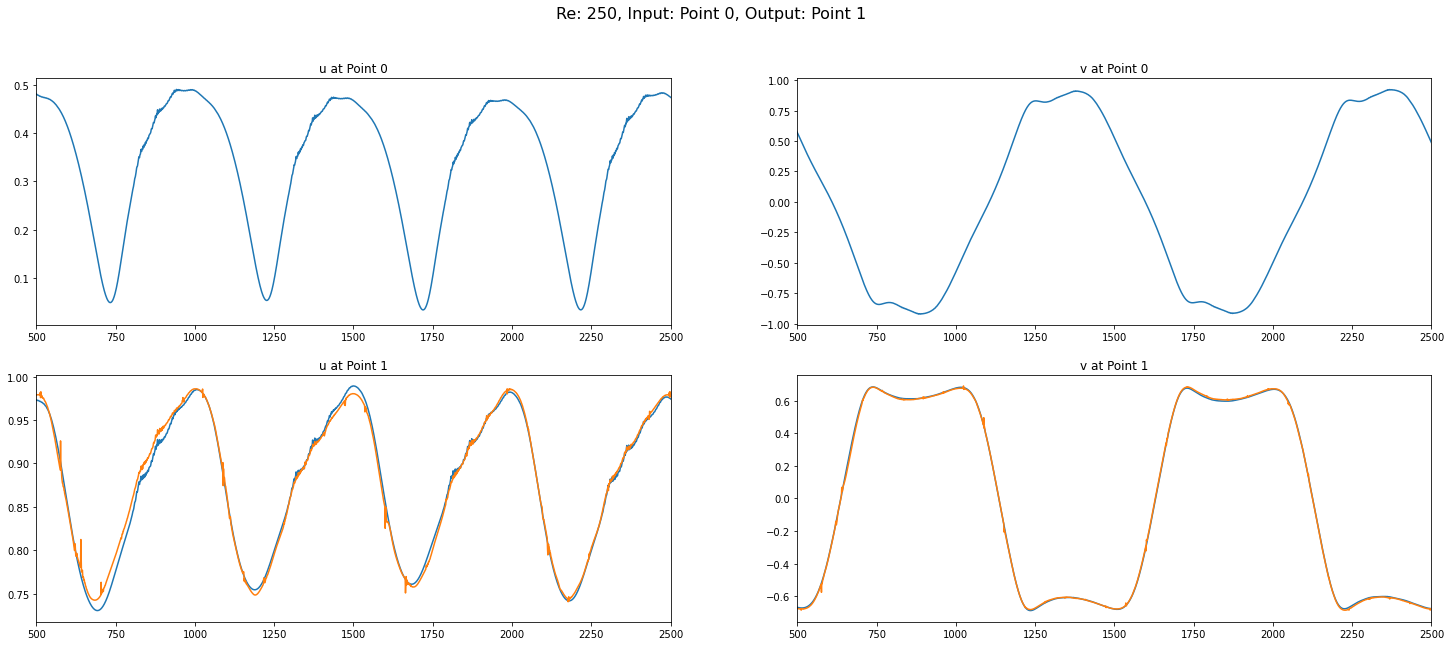

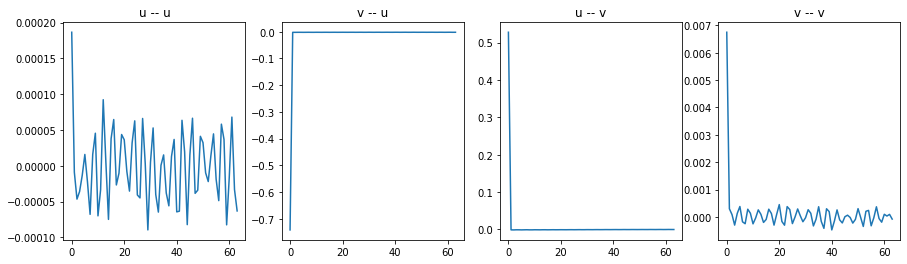

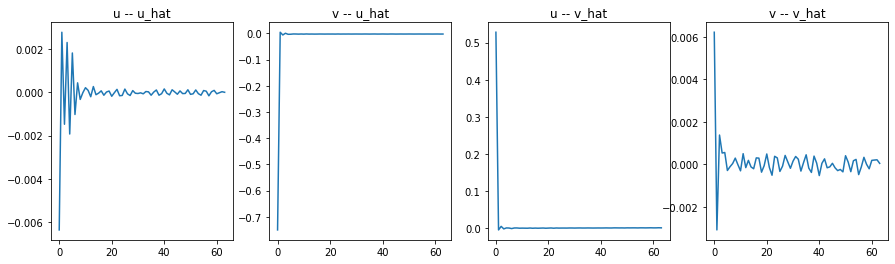

In [126]:
plot_result(re=250,index1=0,index2=1, model='RNN')

In [6]:

def get_slices(array, slice_length, overlap):
    num_slices = (len(array) - overlap) // (slice_length - overlap)

    # Initialize an empty list to store the slices
    slices = []

    # Create overlapping slices
    for i in range(num_slices):
        start = i * (slice_length - overlap)
        end = start + slice_length
        slice_data = array[start:end]
        slices.append(slice_data)
    return np.array(slices)

In [14]:
re = 60
index1 = 0
index2 = 1
data = []

for i in range(6):
    data.append(np.load(f"cyl_cfd/Re{re}/p{i+1}.npy"))

x = get_slices(data[index1], 64, 32)[...,[1,2]]
y = get_slices(data[index2], 64, 32)[...,[1,2]]


In [34]:
import pandas as pd
import re
import re
import glob
pd.options.display.float_format = '{:.3e}'.format
pd.set_option('display.max_rows', 300)

pattern = r'cfd_Re(\d+)_(\d+)_(\d+)_(\w+)'

# Use re.search to find the pattern in the file name
d = {'Re':[], 'index1':[], 'index2':[], 'model':[], 'e':[]}
for file in glob.glob('runs/*'):
    match = re.search(pattern, file)
    if match:
        # Extract X, Y, Z, and W values from the match
        Re = int(match.group(1))
        index1 = int(match.group(2))
        index2 = int(match.group(3))
        model = match.group(4)
        d['Re'].append(Re)
        d['index1'].append(index1)
        d['index2'].append(index2)
        d['model'].append(model)
        error = []
        for checkpoint in glob.glob(f'{file}/version_0/checkpoints/*'):
            pattern1 = r'([^=]+)=([^=]+)=([^=]+)\.ckpt'
            match = re.search(pattern1, checkpoint)
            if match:
                e = float(match.group(3))
                error.append(e)
        d['e'].append(min(error))

In [35]:
df = pd.DataFrame.from_dict(d)

In [36]:
print(df)

      Re  index1  index2        model         e
0     60       4       5          S4D 1.420e-04
1    100       0       5          RNN 3.200e-04
2    250       0       1          RNN 2.020e-05
3    250       4       1          S4D 2.020e-02
4    250       3       5          TCN 1.370e-03
5    100       4       1          S4D 2.430e-03
6    100       4       3          S4D 7.100e-04
7    100       2       3          RNN 3.730e-03
8    250       1       4          RNN 4.840e-03
9    250       1       5          TCN 2.450e-04
10   100       1       3          TCN 3.430e-05
11    60       2       4          TCN 2.900e-06
12   250       1       3          RNN 9.910e-03
13   250       1       5  Transformer 1.290e-01
14    60       1       5  Transformer 2.330e-05
15   250       3       1          TCN 1.820e-03
16   100       4       5          TCN 3.640e-04
17   100       3       2          TCN 7.380e-04
18    60       0       2          RNN 9.900e-04
19   100       4       5          S4D 4.

In [123]:
model_mask = df['model'].isin(['RNN', 'TCN','S4D', 'Transformer'])

# Filter the DataFrame based on the mask
filtered_df = df[model_mask]

# Sort the DataFrame by 'Re', 'index1', 'index2', 'model', and 'e'
sorted_df = filtered_df.sort_values(by=['index1', 'index2', 'model', 'e'])


In [124]:
sorted_df

,Re,index1,index2,model,e
21,100,0,1,RNN,5.910e-06
2,250,0,1,RNN,2.020e-05
85,60,0,1,RNN,2.660e-05
47,60,0,1,S4D,1.600e-05
66,100,0,1,S4D,2.400e-05
99,250,0,1,S4D,4.510e-05
31,100,0,1,TCN,2.550e-06
206,60,0,1,TCN,8.230e-06
141,250,0,1,TCN,1.310e-05
185,250,0,1,Transformer,7.570e-03


In [46]:
df[df['model'].isin(['S4D']) & df['Re'].isin([60])].sort_values('e')

,Re,index1,index2,model,e
47,60,0,1,S4D,1.600e-05
81,60,1,5,S4D,2.040e-05
33,60,2,5,S4D,2.130e-05
205,60,1,4,S4D,3.490e-05
189,60,3,5,S4D,3.530e-05
224,60,2,3,S4D,4.050e-05
198,60,1,3,S4D,4.770e-05
62,60,2,1,S4D,4.780e-05
169,60,2,4,S4D,4.870e-05
160,60,1,2,S4D,4.930e-05


In [125]:
df[df['model'].isin(['TCN']) & df['Re'].isin([100,60,250])].sort_values(['e','index1', 'index2'])

,Re,index1,index2,model,e
191,60,1,4,TCN,7.660e-07
35,60,2,5,TCN,8.420e-07
177,60,1,5,TCN,1.430e-06
91,60,2,1,TCN,1.580e-06
105,100,0,2,TCN,2.280e-06
31,100,0,1,TCN,2.550e-06
76,60,1,3,TCN,2.680e-06
11,60,2,4,TCN,2.900e-06
138,60,4,1,TCN,3.990e-06
43,60,1,2,TCN,4.810e-06


In [57]:
chunks = [list(s[i:i+3]) for i in range(0, len(s), 3)]

In [60]:
res = 0
for chunk in chunks:
    if chunk == [60,100,250]:
        res+=1

In [63]:
res/len(chunks)

0.7142857142857143